**Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import curve_fit

from ovito.io import *
from ovito.modifiers import *
from ovito.pipeline import *

# Packages form Henriks Github
from lammps_logfile import running_mean, get_color_value
from regex_file_collector import Collector
from regex_file_collector.utils import floating_number_pattern

**Sigmoidal function**

In [2]:
def sigmoid(x, c, b, a):
    z = b*(x-c)
    return a*np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

**Laplace of Gaussian**

Equation found at: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm

In [3]:
def laplaceOfGaussian(x, y, sigma):
    LoG = -1.0/(np.pi * sigma**4) * (1.0-((x**2 + y**2)/(2*sigma**2))) * np.exp(-((x**2 + y**2)/(2*sigma**2)))
    return LoG

**Function: Trajectory to fracture displacement file**

In [4]:
def trajectory_to_fracture_displacement(filename, n_bins=10, reference_frame=7):
    
    # Read in trajectory-file
    pipeline = import_file(filename, multiple_frames=True)

    position_crack_tip = []
    frames = []
    
    frames_posCrack = []
    
    extra_zeros = np.zeros((50))

    for frame in range(reference_frame, pipeline.source.num_frames):
        
        # Coordination analysis:
        pipeline.modifiers.append(CoordinationAnalysisModifier(
            number_of_bins = n_bins, 
            partial = True))

        # Expression selection:
        pipeline.modifiers.append(ExpressionSelectionModifier(
            expression = 'Coordination>=4 || ParticleType==2'))

        # Delete selected:
        pipeline.modifiers.append(DeleteSelectedModifier())

        # Spatial binning:
        pipeline.modifiers.append(SpatialBinningModifier(
            property = 'Coordination', 
            reduction_operation = SpatialBinningModifier.Operation.Sum, 
            direction = SpatialBinningModifier.Direction.X, 
            bin_count = (95, 200, 200)))

        #Extract and save data as a table
        data = pipeline.compute(frame)
        table = data.tables['binning'].xy()

        pos_x = table[:,0]
        coord = table[:,1]
        
        mean_pos_x = running_mean(pos_x, 10)
        mean_coord = running_mean(coord, 10)

        pos_x = mean_pos_x[7:-7]
        coord = mean_coord[7:-7]

        diff_pos = pos_x[1]-pos_x[0]

        # Add extra zeroes at the end to get a better fit
        new_pos = []
        for i in range (0, len(extra_zeros)):
            new_pos.append(pos_x[-1]+diff_pos*i)

        pos_x = np.insert(pos_x, len(pos_x), new_pos)
        coord = np.insert(coord, len(coord), extra_zeros)

        # Make a sigmoidal fit
        popt = [200]

        try:
            popt, pcov = curve_fit(sigmoid, pos_x, coord, p0=[popt[0], 0.001, (pos_x[0]+pos_x[-1])/2])
        except RuntimeError as e: 
            print(e)
            popt = [-1]
                
        position_crack_tip.append(popt[0])
        
    return position_crack_tip

**Function: Save as file**

In [9]:
def save_fracture_displacement(filename, overwrite=True, **kwargs):
    outfile = "fracture_displacement"
    
    folder = os.path.dirname(filename)
    
    if overwrite or not os.path.isfile(os.path.join(folder, outfile+".npy")):
        position_crack_tip = trajectory_to_fracture_displacement(filename, **kwargs)
        np.save(os.path.join(folder,outfile), position_crack_tip, allow_pickle=False)

**Select folder with input files**

In [10]:
path = '/home/users/marthgg/simulations/x3000_y200/vary_deformZ'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/trajectory.bin'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

The pattern contains 1 capturing groups
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.007497/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.022224/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.030002/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.029500/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.042279/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.033057/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.025856/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.018606/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.003767/trajectory.bin
/home/users/mar

**Use functions to save output**

In [11]:
for deformZ, path in simulations.items():
    
    filename = path
    print(filename)
    
    save_fracture_displacement(filename)

/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.007497/trajectory.bin
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.


/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too smal

<ipython-input-2-9b105c2bc495>:3: RuntimeWarning: overflow encountered in exp
  return a*np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
<ipython-input-2-9b105c2bc495>:3: RuntimeWarning: invalid value encountered in true_divide
  return a*np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))


/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.029500/trajectory.bin
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.042279/trajectory.bin
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.033057/trajectory.bin
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.
Optimal pa

**Read in data saved as .npy**

The pattern contains 1 capturing groups
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.007497/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.022224/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.030002/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.029500/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.042279/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.033057/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.025856/fracture_displacement.npy
/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.018606/fracture_displacement.npy
/home/users/marthgg/simulations/

/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/marthgg/.pyenv/versions/md_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


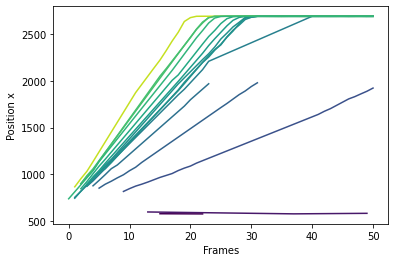

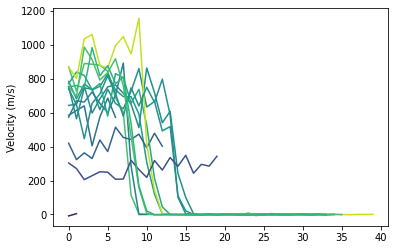

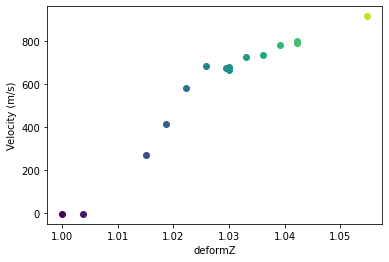

In [17]:
path = '/home/users/marthgg/simulations/x3000_y200/vary_deformZ'
pattern = 'crack_simulation_'+floating_number_pattern('deformZ')+'/fracture_displacement.npy'

collection = Collector(path, pattern, fields=('deformZ'))
simulations = collection.get_flat()

system_length = 3000
crack_start_point = 150

for deformZ, path in simulations.items():
    
    filename = path
    
    data = np.load(filename, allow_pickle=False)
    frames = list(range(0, len(data)))
    
    filtered_data_crackTip = []
    filtered_data_frames   = []
    
    for i in range(0, len(data)):
        if data[i] > crack_start_point and data[i] < system_length:
            filtered_data_crackTip.append(data[i])
            filtered_data_frames.append(frames[i])
            
    
    plt.figure(1)
    plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.060000))
    plt.xlabel('Frames')
    plt.ylabel('Position x')
    
    
    # Find velocity
    timestep = 0.001 # ps
    dump_frequency = 10000
    
    time_s = []
    for i in range(0, len(filtered_data_frames)):
        time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s
        
    position_m = []
    for i in range(0, len(filtered_data_crackTip)):
        position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m
        
    velocity = np.diff(position_m)/np.diff(time_s)
    
    plt.figure(2)
    plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.060000))#, label=deformZ)
    plt.ylabel('Velocity (m/s)')
    
    velocity_crack = []
    for i in range (0, len(velocity)):
        if filtered_data_crackTip[-1] > 2500:
            if velocity[i] < 400:
                break
            else:
                velocity_crack.append(velocity[i])
        else:
            velocity_crack.append(velocity[i])
                
    mean_velocity = np.mean(velocity_crack)

    plt.figure(3)
    plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.060000))
    plt.xlabel('deformZ')
    plt.ylabel('Velocity (m/s)')

Text(0, 0.5, 'Velocity (m/s)')

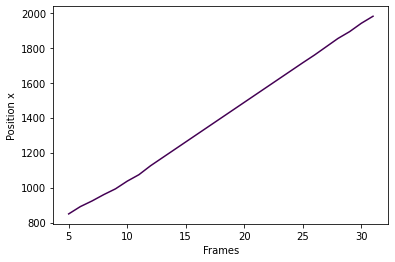

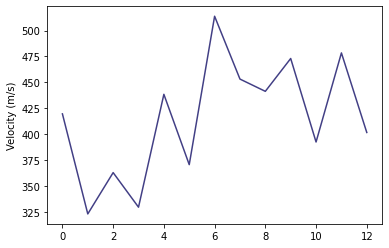

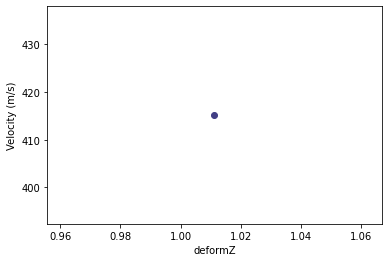

In [18]:
system_length = 3000
crack_start_point = 150

    
filename = '/home/users/marthgg/simulations/x3000_y200/vary_deformZ/crack_simulation_deformZ_1.018606/fracture_displacement.npy'

data = np.load(filename, allow_pickle=False)
frames = list(range(0, len(data)))

filtered_data_crackTip = []
filtered_data_frames   = []

for i in range(0, len(data)):
    if data[i] > crack_start_point and data[i] < system_length:
        filtered_data_crackTip.append(data[i])
        filtered_data_frames.append(frames[i])


plt.figure(1)
plt.plot(filtered_data_frames, filtered_data_crackTip, color=get_color_value(float(deformZ), 1.000000, 1.060000))
plt.xlabel('Frames')
plt.ylabel('Position x')


# Find velocity
timestep = 0.001 # ps
dump_frequency = 10000

time_s = []
for i in range(0, len(filtered_data_frames)):
    time_s.append(filtered_data_frames[i]*timestep*dump_frequency*(10**-12)) #time in s

position_m = []
for i in range(0, len(filtered_data_crackTip)):
    position_m.append(filtered_data_crackTip[i]*(10**-10)) #distance in m

velocity = np.diff(position_m)/np.diff(time_s)

plt.figure(2)
plt.plot(velocity, color=get_color_value(float(deformZ), 1.00000, 1.060000))#, label=deformZ)
plt.ylabel('Velocity (m/s)')

velocity_crack = []
for i in range (0, len(velocity)):
    if filtered_data_crackTip[-1] > 2800:
        if velocity[i] < 400:
            break
        else:
            velocity_crack.append(velocity[i])
    else:
        velocity_crack.append(velocity[i])

mean_velocity = np.mean(velocity_crack)

plt.figure(3)
plt.plot(float(deformZ), mean_velocity, 'o', color=get_color_value(float(deformZ), 1.00000, 1.060000))
plt.xlabel('deformZ')
plt.ylabel('Velocity (m/s)')